# Import Ntuple

In [2]:
%load_ext autoreload
%autoreload 2

import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

Welcome to JupyROOT 6.26/14


In [2]:
# 4S Data vs MC

cut = '(1.855<D_M) & (D_M<1.885) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_4S = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_1ab_quaxo_e_2/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

data_4S = uproot.concatenate([f'../../Samples/Data/e_channel/proc13_4S_quaxo_4.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S)
df_data_4S = pd.DataFrame(data_4S)

In [3]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

for df in [df_mc_4S,df_data_4S,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_tight, library='lgbm')
df_data_4S_lgb = util.apply_mva_bcs(df_data_4S, training_variables, lgb_tight, library='lgbm')

In [6]:
columns_without_nan = df_data_4S_lgb.columns[~df_data_4S_lgb.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_4S_lgb, 'e', template=False)
mpl=util.mpl(samples,df_data_4S_lgb)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 17563
bkg_TDFl 7187
bkg_fakeTracks 1917
bkg_continuum 16273
bkg_combinatorial 17806
bkg_singleBbkg 10562
bkg_other_TDTl 0
$D\tau\nu$ 4445
$D^\ast\tau\nu$ 2641
$D\ell\nu$ 94669
$D^\ast\ell\nu$ 60537
$D^{\ast\ast}\tau\nu$ 1594
$D^{\ast\ast}\ell\nu$_narrow 19573
$D^{\ast\ast}\ell\nu$_broad 14998
$D\ell\nu$_gap_pi 3756
$D\ell\nu$_gap_eta 3361
bkg_other_signal 0


# Control regions

### 1. roeMbc<5

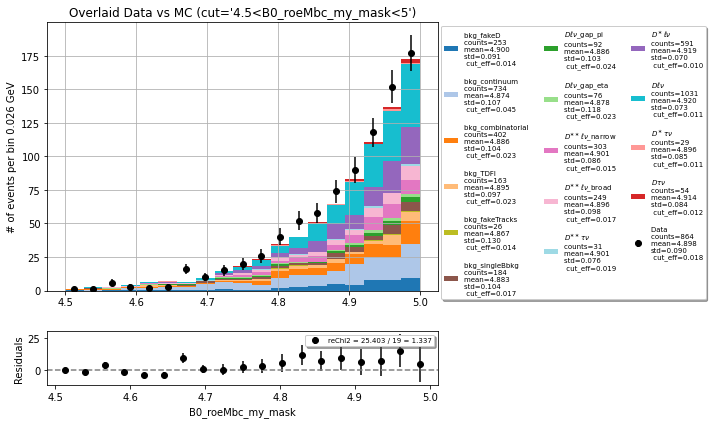

In [7]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(4.5,5,20)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_roeMbc_my_mask',bins=b1,cut='4.5<B0_roeMbc_my_mask<5',scale=[1,187/1000],
    correction=False,mask=[],figsize=(10,6),ratio=False,
                                legend_nc=3, legend_fs=7)

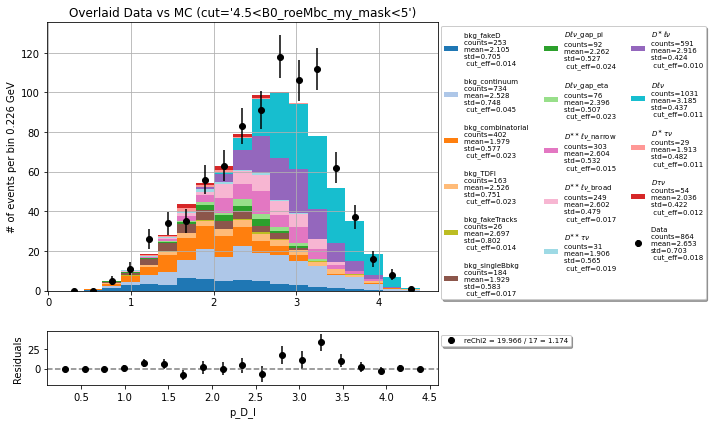

In [8]:
# signal
b2 = np.linspace(0.2,4.5,20)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
            cut='4.5<B0_roeMbc_my_mask<5',scale=[1,187/1000],
            correction=False,mask=[],figsize=(10,6),legend_nc=3, legend_fs=7)

### 2. q^2 < 3

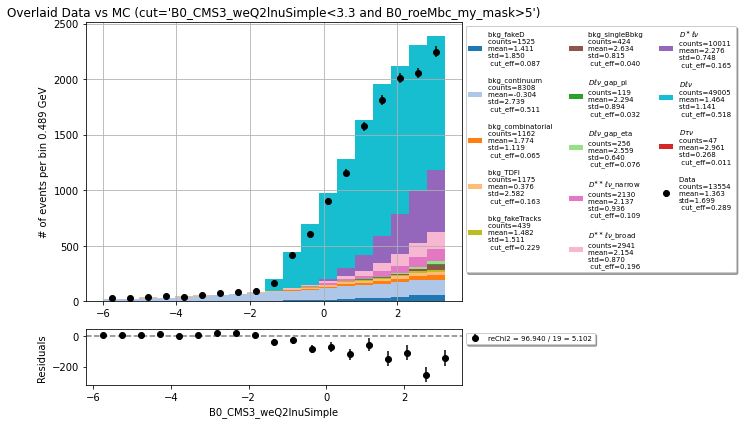

In [10]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(-6,3.3,20)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weQ2lnuSimple',bins=b1,
    cut='B0_CMS3_weQ2lnuSimple<3.3 and B0_roeMbc_my_mask>5',
    correction=False,mask=[],figsize=(10,6),ratio=False,
    scale=[1,187/1000],legend_nc=3, legend_fs=7)

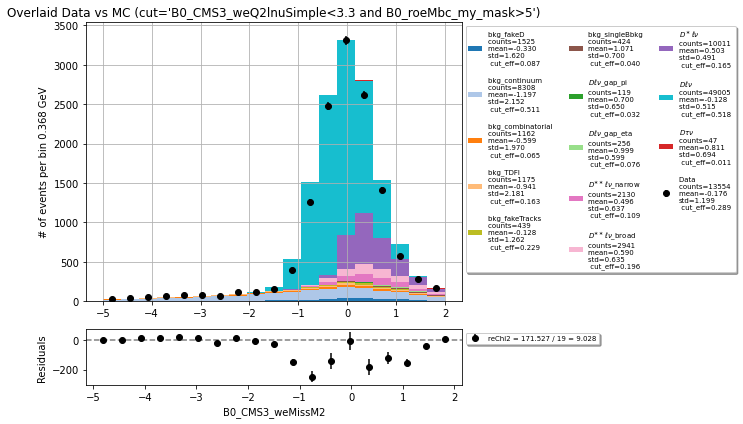

In [12]:
# signal
b1 = np.linspace(-5,2,20)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,figsize=(10,6),
                          cut='B0_CMS3_weQ2lnuSimple<3.3 and B0_roeMbc_my_mask>5',
                          scale=[1,187/1000],correction=False,mask=[],ratio=False,
                                                      legend_nc=3, legend_fs=7)